# Import and Init

# 1.1 Python and Stuffs

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import os

# Définir le backend souhaité (par exemple, 'tensorflow' ou 'theano')
backend = 'torch'  # Remplacez 'tensorflow' par le backend de votre choix

# Définir la variable d'environnement KERAS_BACKEND
os.environ['KERAS_BACKEND'] = backend

# Importer Keras après avoir défini la variable d'environnement


import PIL
from PIL import Image

In [4]:
import keras


In [5]:
import h5py

# 1.2 Parameters

In [6]:
# filesystem
Data_dir="/home/onyxia/work/AutoEncoder/Data"
Codes_dir="/home/onyxia/work/AutoEncoder/Codes"
Outputs_dir="/home/onyxia/work/AutoEncoder/Outputs"

# Preprocessing 

# Model

2 Load  Data

In [33]:
def retrieve_data(filename) :
    with h5py.File(Data_dir+"/"+filename, 'r') as f:
    # Créer un dataset
       x_train=  f['x_train'][:] 
       y_train=  f['y_train'][:]
       y_train_img=  f['y_train_img'][:] 
       x_test=  f['x_test'][:] 
       y_test=  f['y_test'][:] 
       y_test_img=  f['y_test_img'][:] 

    return x_train,y_train_img,y_train,x_test,y_test_img,y_test

In [35]:
x_train,y_train,_,x_test,y_test,_=retrieve_data("Dataset_Images.h5")

In [135]:
_,_,_,_,_,y_test_classes=retrieve_data("Dataset_Images.h5")

In [36]:
x_train.shape

(8000, 28, 28)

In [37]:
y_train.shape

(8000, 28, 28)

3 BUILD MODEL

3.1 ENCODER Model


In [10]:
input_shape=(28,28)
shape= input_shape+tuple([1])
shape

(28, 28, 1)

In [11]:
def simple_encoder(input_shape,cl,dl,latent_dim,activation="relu",name="encoder",strides=2,padding="same"):
    n_filter=cl['n_filter']
    kernel_size=cl['kernel_size']
    dl_size=dl['dl_size']
    dl_activation=dl["activation"]
    
    inputs=keras.Input(shape= input_shape+tuple([1]),name="Input_Layers")
    
     # add Convolution Layers
    x=keras.layers.Conv2D(n_filter,kernel_size,strides=strides,padding=padding,name="Conv2D_1")(inputs)
    x=keras.layers.Conv2D(n_filter,kernel_size,strides=strides,padding=padding,name="Conv2D_2")(x)
    x=keras.layers.Conv2D(n_filter,kernel_size,strides=strides,padding=padding,name="Conv2D_3")(x)
     
     # add Flatten layers
    x=keras.layers.Flatten(name="Flatten")(x)
    
     # add Dense Layers
    x=keras.layers.Dense(dl_size,activation=dl_activation,name="Dense_1")(x)
    x=keras.layers.Dense(int(dl_size/2),activation=dl_activation,name="Dense_2")(x)
    x=keras.layers.Dense(int(dl_size/4),activation=dl_activation,name="Dense_3")(x)



    ouputs_Encoder=keras.layers.Dense(latent_dim,activation=activation,name="Dense_output")(x)

    # define model

    encoder=keras.models.Model(inputs,ouputs_Encoder,name="Encoder")

    return encoder

In [12]:
def conv_layer_params(n_filter=32,kernel_size=(3,3)):
    cl={}
    cl["n_filter"]=n_filter
    cl["kernel_size"]=kernel_size
    return cl


In [13]:
def dense_layer_params(dl_size=100,activation="relu"):
    dl={}
    dl["dl_size"]=dl_size
    dl["activation"]=activation
    return dl

In [14]:
cl=conv_layer_params()
dl=dense_layer_params()
input_shape=(28,28)
latent_dim=10
encoder=simple_encoder(input_shape,cl,dl,latent_dim,activation="relu",name="encoder",strides=2,padding="same")

In [15]:
encoder.summary()

Model: "Encoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ Input_Layers (InputLayer)       │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Conv2D_1 (Conv2D)               │ (None, 14, 14, 32)        │        320 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Conv2D_2 (Conv2D)               │ (None, 7, 7, 32)          │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Conv2D_3 (Conv2D)               │ (None, 4, 4, 32)          │      9,248 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Flatten (Flatten)               │ (None, 512)               │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Dense_1 (Dense)                 │ (None, 100)               │     51,300 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Dense_2 (Dense)                 │ (None, 50)                │      5,050 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Dense_3 (Dense)                 │ (None, 25)                │      1,275 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Dense_output (Dense)            │ (None, 10)                │        260 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 76,701 (299.61 KB)

 Trainable params: 76,701 (299.61 KB)

 Non-trainable params: 0 (0.00 B)

 Ajout fonction qui definit la partie décoder

In [16]:
def decoder(input_len,dl1,Tcl1,padding="same",strides=2,output_decoder_shape=(28,28,1)):
   dl1_len=dl1["dl_size"]
   dl1_activation=dl1["activation"]
   dl2_len=int(dl1_len*2)
   dl3_len=49*int((dl2_len*2)/49) # je multiplie et je divise par 49 pour pourvoir à la suite extraire un reshape de la forme (7,7,x)tp 7*7*x=dl3_len
   RshapeL_shape=(7,7,int(dl3_len/49))
   Tcl1_len=Tcl1["n_dilator"] #kernel_size
   Tcl1_kernel_size=Tcl1["kernel_size"]  # activation
   Tcl1_activation=Tcl1["activation"]

# Add inputs layers
   inputs=keras.Input((latent_dim,),name="input_decoder")
# add Dense
   x=keras.layers.Dense(dl1_len,activation=dl1_activation,name="Dense1")(inputs)
   x=keras.layers.Dense(dl2_len,activation=dl1_activation,name="Dense2")(x)
   x=keras.layers.Dense(dl3_len,activation=dl1_activation,name="Dense3")(x)

# Reshape Layers
   x=keras.layers.Reshape(RshapeL_shape)(x)


# Add Transposed Convolutions layers
   x=keras.layers.Conv2DTranspose(Tcl1_len,Tcl1_kernel_size,activation=Tcl1_activation,padding=padding,strides=strides,name="TC1")(x)
   x=keras.layers.Conv2DTranspose(Tcl1_len*2,kernel_size=Tcl1_kernel_size,activation=Tcl1_activation,padding=padding,strides=strides,name="TC2")(x)
   #x=keras.layers.Conv2DTranspose(Tcl1_len*4,kernel_size=Tcl1_kernel_size,activation=Tcl1_activation,padding=padding,strides=strides,name="TC3")(x)

# add output decoder layers
   outputs_decoder=keras.layers.Conv2DTranspose(1,kernel_size=(3,3),activation=Tcl1_activation,padding="same",strides=1,name="TC_output")(x)
 
   decoder=keras.models.Model(inputs,outputs_decoder,name="decoder")

   return decoder

In [17]:
def Tconv_layer_params(n_dilator=32,kernel_size=(3,3),activation="relu"):
    Tcl={}
    Tcl["n_dilator"]=n_dilator
    Tcl["kernel_size"]=kernel_size
    Tcl["activation"]=activation
    return Tcl

In [18]:
Tcl1=Tconv_layer_params()
Tcl1


{'n_dilator': 32, 'kernel_size': (3, 3), 'activation': 'relu'}

In [19]:
dl1=dense_layer_params()
dl1

{'dl_size': 100, 'activation': 'relu'}

In [20]:
input_len=10
decoder=decoder(input_len,dl1,Tcl1,padding="same",strides=2,output_decoder_shape=(28,28,1))


In [21]:
decoder.summary()

Model: "decoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_decoder (InputLayer)      │ (None, 10)                │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Dense1 (Dense)                  │ (None, 100)               │      1,100 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Dense2 (Dense)                  │ (None, 200)               │     20,200 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Dense3 (Dense)                  │ (None, 392)               │     78,792 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ reshape (Reshape)               │ (None, 7, 7, 8)           │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ TC1 (Conv2DTranspose)           │ (None, 14, 14, 32)        │      2,336 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ TC2 (Conv2DTranspose)           │ (None, 28, 28, 64)        │     18,496 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ TC_output (Conv2DTranspose)     │ (None, 28, 28, 1)         │        577 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 121,501 (474.61 KB)

 Trainable params: 121,501 (474.61 KB)

 Non-trainable params: 0 (0.00 B)

 AutoEncoder 

In [22]:
def autoencoder(inputs_shape=(28,28,1),encoder=encoder,decoder=decoder):
    inputs=keras.Input(inputs_shape)
    latent=encoder(inputs)
    ouputs=decoder(latent)
    ae=keras.models.Model(inputs,ouputs,name="AutoEncoder")

    return ae

In [23]:
ae=autoencoder()

In [24]:
ae.summary()

Model: "AutoEncoder"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape              ┃    Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 28, 28, 1)         │          0 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ Encoder (Functional)            │ (None, 10)                │     76,701 │
├─────────────────────────────────┼───────────────────────────┼────────────┤
│ decoder (Functional)            │ (None, 28, 28, 1)         │    121,501 │
└─────────────────────────────────┴───────────────────────────┴────────────┘

 Total params: 198,202 (774.23 KB)

 Trainable params: 198,202 (774.23 KB)

 Non-trainable params: 0 (0.00 B)

# 4 TRAINING

# 4.0 ADD Call back

In [82]:
from keras.callbacks import Callback

class TrackPredictions(keras.callbacks.Callback):
    def __init__(self, input_data):
        super(TrackPredictions, self).__init__()
        self.input_data = input_data
        self.predictions_history = []

    def on_epoch_end(self, epoch, logs=None):
        predictions = self.model.predict(np.array(self.input_data))
        self.predictions_history.append(predictions)

In [132]:
label=y_test_classes[:batch_size]


In [87]:
batch_size=32

input_data = x_test_normalized[:batch_size]   # Votre entrée donnée
# Votre entrée donnée
#input_data = np.array(input_data)

# Changer la forme en (None, 28, 28, 1) avec None=32
#input_data_resized = input_data.reshape( 28, 28, 32)

prediction_callback = TrackPredictions(input_data.reshape(32, 28, 28, 1))

In [83]:
input_data.shape

(32, 28, 28)

## 4.1 Compile model

In [62]:
optimizer="Adam"
loss="binary_crossentropy"
metrics=["accuracy"]

In [63]:
ae.compile(optimizer=optimizer,loss=loss,metrics=metrics)

## 4.2 Fit the model 

In [40]:
x_train_normalized = x_train / 255.0
x_test_normalized = x_test / 255.0
y_train_normalized = y_train / 255.0
y_test_normalized = y_test / 255.0


In [104]:
x_train.shape

(8000, 28, 28)

In [88]:
batch_size=32
histoiry_=ae.fit(x_train_normalized,y_train_normalized,epochs=5,batch_size=batch_size,callbacks=[prediction_callback],validation_data=[x_test_normalized,y_test_normalized])


Epoch 1/5
  1/250 ━━━━━━━━━━━━━━━━━━━━ 15s 63ms/step - accuracy: 0.8030 - loss: 0.2743

  3/250 ━━━━━━━━━━━━━━━━━━━━ 13s 53ms/step - accuracy: 0.7984 - loss: 0.2729

/home/onyxia/work/AutoEncoder/Codes/AE_env/lib/python3.11/site-packages/keras/src/backend/common/backend_utils.py:88: UserWarning: You might experience inconsistencies accross backends when calling conv transpose with kernel_size=3, stride=2, dilation_rate=1, padding=same, output_padding=1.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/stepstep - accuracy: 0.8001 - loss: 0.272
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step - accuracy: 0.8001 - loss: 0.2722 - val_accuracy: 0.7993 - val_loss: 0.2667
Epoch 2/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step/step - accuracy: 0.8006 - loss: 0.27
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.8006 - loss: 0.2714 - val_accuracy: 0.8060 - val_loss: 0.2664
Epoch 3/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step/step - accuracy: 0.7999 - loss: 0.27
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 44ms/step - accuracy: 0.7999 - loss: 0.2744 - val_accuracy: 0.7994 - val_loss: 0.2660
Epoch 4/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step/step - accuracy: 0.7994 - loss: 0.26
250/250 ━━━━━━━━━━━━━━━━━━━━ 11s 43ms/step - accuracy: 0.7994 - loss: 0.2657 - val_accuracy: 0.8025 - val_loss: 0.2641
Epoch 5/5
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/stepstep - accuracy: 0.7982 - loss: 0.265
250/250 ━━━━━━━━━━━━━━━━━━━━ 12s 47ms/step - accuracy: 0.7982 - loss: 0.2652 - val_accuracy: 0.8043 - val_loss: 

# 4.3 Plot histoire


In [89]:
# liste de tous les noms des objets dans le diction de l'historique du model
histoiry_.history.keys()

dict_keys(['accuracy', 'loss', 'val_accuracy', 'val_loss'])

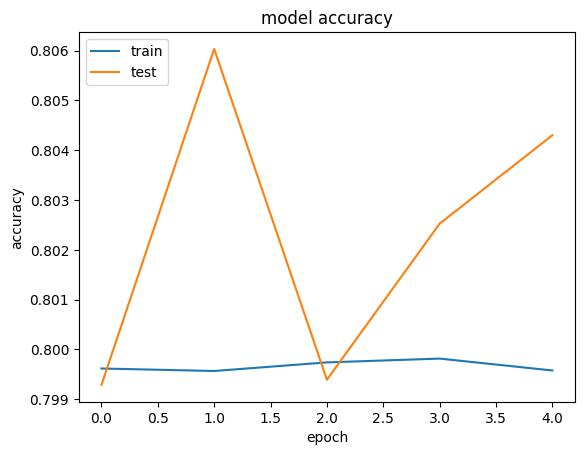

In [91]:
# summarize history for loss
plt.plot(histoiry_.history['accuracy'])
plt.plot(histoiry_.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [92]:
# Acceder à l'historique des predictions
predictions_history = prediction_callback.predictions_history


In [93]:
type(predictions_history)

list

In [94]:
len(predictions_history)

5

In [95]:
type(predictions_history[0])

numpy.ndarray

In [97]:
print("donc 32 images de taille 28*28")
predictions_history[0].shape


donc 32 images de taille 28*28


(32, 28, 28, 1)

In [141]:
array_image=predictions_history[0][1]
array_image=np.array(255*array_image.reshape(1,28,28),dtype='int')
print('Done')


Done


In [103]:
255*array_image[:,:0]

array([], shape=(28, 0, 1), dtype=float32)

In [125]:
def get_real_image(image_data):
    images_real = []
    for img_matrix in image_data:
        img_matrix = img_matrix.astype(np.uint8)
        img = Image.fromarray(img_matrix)
        images_real.append(np.array(img))

    return images_real

In [124]:
def history_predition(predictions_history,j): # i est la position de l'image dans le dataset des imgages dont je sui l'évolution
    image_progres=predictions_history[:][j]
    n=len(predictions_history)
    images=[]
    for i in range(n):
        array_image=predictions_history[i][j]
        array_image=np.array(255*array_image.reshape(1,28,28),dtype='int')
        #liste_images=[array_image[i] for i in range(n)]
        images.append(get_real_image(array_image)[0])


    return images

In [128]:
images=history_predition(predictions_history,0)

In [138]:
image_labesl=[y_test_classes[1] for i in range(5)]
index_images=range(5)
images=images
def show_image(index_images=index_images,images=images,figsize=(10,5),image_labesl=image_labesl):
    n=len(index_images) # n=num_images_to_show
    plt.figure(figsize=figsize)
    for i in range(n):
         plt.subplot(1, n, i + 1)
         plt.imshow(images[index_images[i]].squeeze(), cmap='gray')

         #plt.imshow(images[index_images[i]], cmap='gray')
         plt.title(f"Label: {image_labesl[index_images[i]]}")
         plt.axis('off')
    plt.show()

In [139]:
y_test_classes

array([0, 8, 4, ..., 4, 5, 2], dtype=uint8)

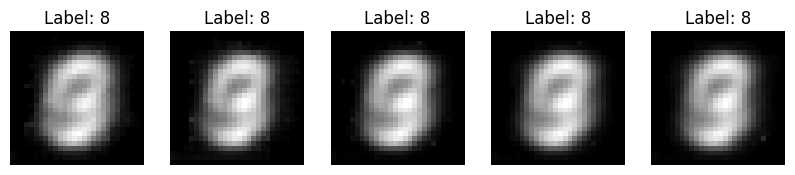

In [140]:
show_image()